# Test New DAQ

## Authors: JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

### Description:

- Run 6884. Feburary 2019. Low background run, closed castle, no sources, 7.7 kV, ENRICHED XENON, high krypton rate, new DAQ


In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Sat Feb 16 12:10:30 2019


In [2]:
run_number  = 6884
file_range  = 0, 1719

input_path  = f"$IC_DATA/kdst"
output_path = f"$IC_DATA/dst"
log_path    = f"$IC_DATA/log"
trigger     = 'trigger1'
tags        = 'v0.9.9_20190111_krbg'

bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"
write_filtered_dst = True

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob
import seaborn as sns
sns.set()

In [5]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units


In [6]:
from krcal.core.io_functions       import filenames_from_paths
from krcal.core.io_functions       import write_monitor_vars
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [7]:
from krcal.core.kr_types           import PlotLabels
from krcal.core.analysis_functions import kr_ranges_and_bins
from krcal.core.analysis_functions import kr_event
from krcal.core.analysis_functions import selection_info
from krcal.core.analysis_functions import selection_in_band
from krcal.core.analysis_functions import plot_selection_in_band
from krcal.core.s1s2_functions     import s1d_from_dst
from krcal.core.s1s2_functions     import s2d_from_dst
from krcal.core.s1s2_functions     import plot_s1histos
from krcal.core.s1s2_functions     import plot_s2histos

In [8]:
from krcal.core.plt_functions      import plot_xy_density
from krcal.core.plt_functions      import plot_s1_vs_z
from krcal.core.plt_functions      import plot_s2_vs_z
from krcal.core.plt_functions      import plot_s2_vs_s1
from krcal.core.plt_functions      import plot_q_vs_s2
from krcal.core.plt_functions      import plot_energy_distributions
from krcal.core.plt_functions      import plot_energy_vs_t


In [9]:
import krcal.dev.corrections       as corrections 
import krcal.utils.hst_extend_functions as hst

In [10]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core import fit_functions_ic as fitf
from krcal.core.histo_functions import profile1d

### Input/output 

In [11]:
input_dst_filenames, output_dst_filename, log_filename = filenames_from_paths(run_number,
                                                                              input_path,
                                                                              output_path,
                                                                              log_path,
                                                                              trigger,
                                                                              tags,
                                                                              file_range)
                                                                              
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"log file   = {log_filename}")                       

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6884/kdst_0000_6884_trigger1_v0.9.9_20190111_krbg.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6884/kdst_1718_6884_trigger1_v0.9.9_20190111_krbg.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6884_trigger1_0000_1718.h5
log file   = /Users/jjgomezcadenas/Projects/ICDATA/log/log_6884_trigger1_0000_1718.h5


In [12]:
dst_full           = load_dsts(input_dst_filenames, "DST", "Events")

In [13]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 599592 
Total number of events: 456054


In [14]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [15]:
ntot = len(dst_full)
print(f"length of dst = {ntot}")

length of dst = 599592


### S1/S2

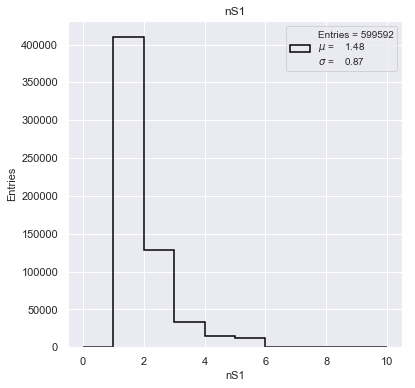

In [16]:
n, b, _, _ = h1d(dst_full.nS1.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS1', y='Entries', title='nS1'))

In [17]:
fnS1 = n[n.argmax()]/np.sum(n)
print(f'fraction of S1s = {fnS1}')

fraction of S1s = 0.6844304126806228


### Select events with 1 S1

In [18]:
dst1s1 = dst_full[in_range(dst_full.nS1, 1,2)]

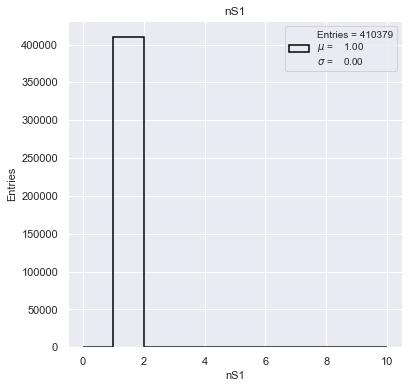

In [19]:
n, b, _, _ = h1d(dst1s1.nS1.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS1', y='Entries', title='nS1'))

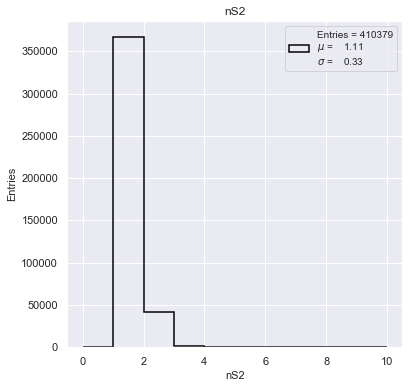

In [20]:
n, b, _, _ = h1d(dst1s1.nS2.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS2', y='Entries', title='nS2'))

#### For Krypton select events with  1 S2

In [21]:
fnS2 = n[n.argmax()]/np.sum(n)
print(f'fraction of S2s = {fnS2}')

fraction of S2s = 0.8948874089561113


### Select events with 1 S2

In [22]:
dst    = dst1s1[in_range(dst1s1.nS2, 1, 2)]

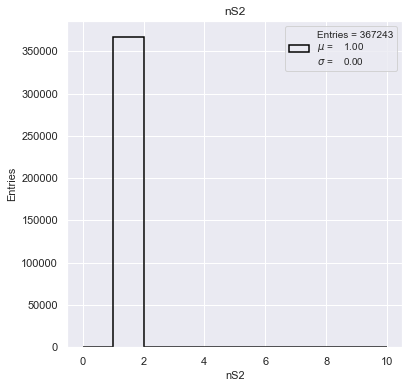

In [23]:
n, b, _, _ = h1d(dst.nS2.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS2', y='Entries', title='nS2'))

In [24]:
n_full   = len(dst)
eff = n_full   / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {n_full}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 367243: selection eff = 0.6124881586145245 


### S1 and S2 distributions

In [25]:
s1d = s1d_from_dst(dst)

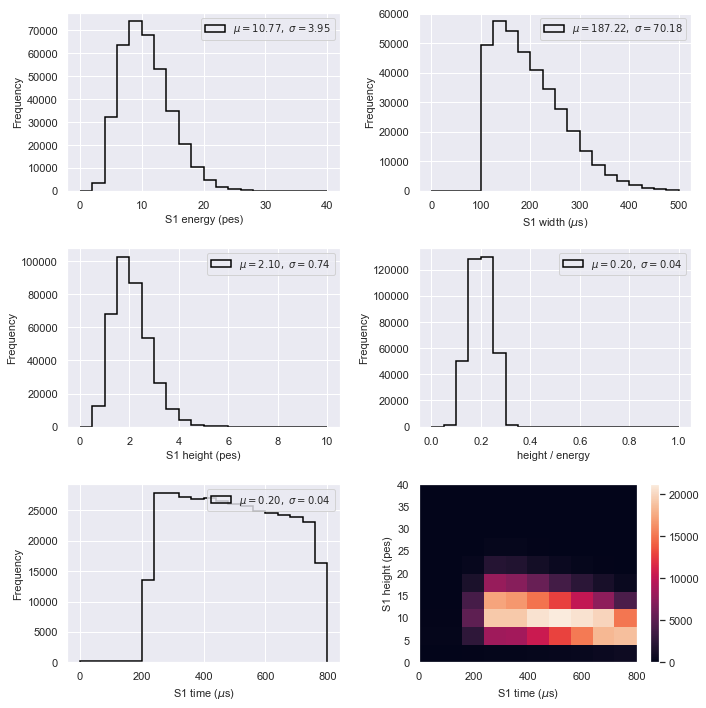

In [26]:
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

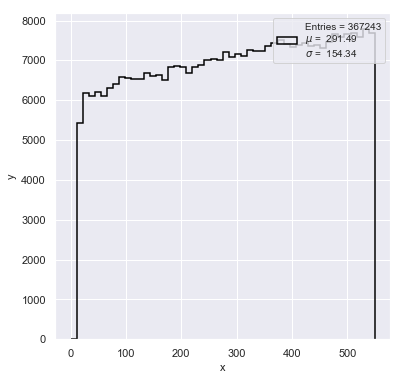

In [27]:
(_) = h1d(dst.Z, bins = 50, range =(0,550))

#### NB! Correct Z distribution for Z events!

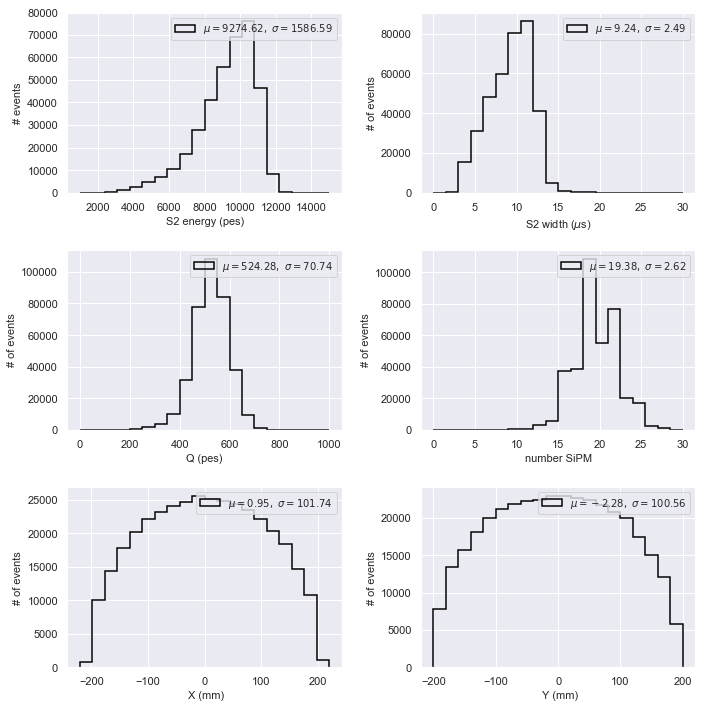

In [28]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### Time differences in seconds

### Define ranges and bins

In [29]:
RMAX      = 200
RFID      = 180
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 6000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 50,
                                                        ynbins    = 50,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 50,
                                                        s2qnbins  = 50,
                                                        tpsamples = 3600) # tsamples in seconds

## Radial Cut

In [31]:
dst     = dst[dst.R < RMAX]

### Time
- Extension in hours of data sample considered

In [35]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

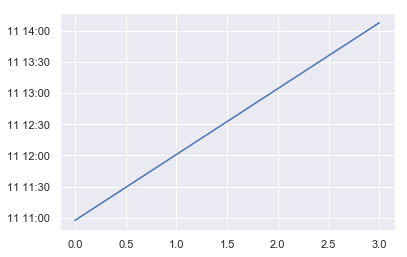

In [36]:
plt.plot(krTimes.timeStamps)

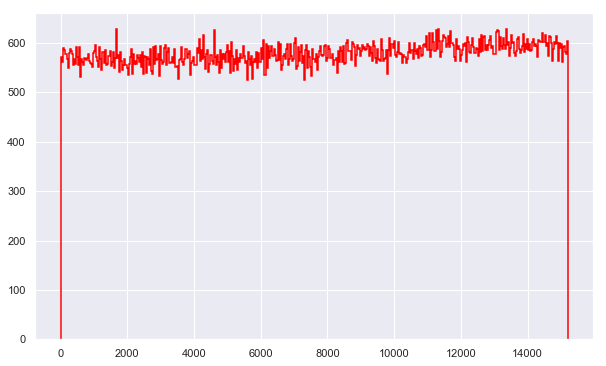

In [39]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(DT, bins=500, range = (DT[0], DT[-1]), color='red', stats=False, lbl='pre-sel')

#### Krypotn raising up and decaying in chamber

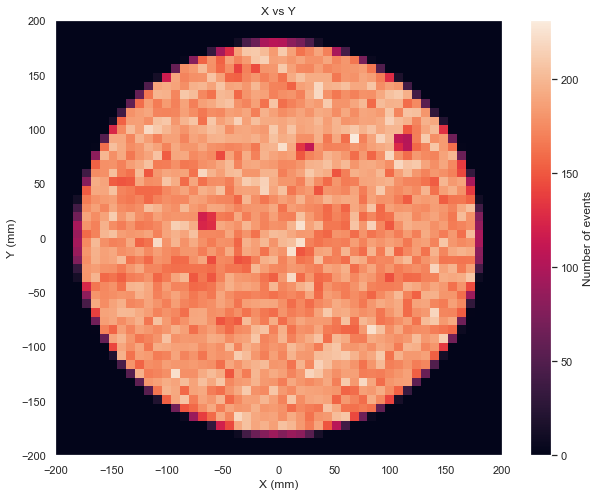

In [40]:
nevt = h2d(dst.X, dst.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y'),
           profile=False,
           figsize=(10,8))

## Z distribution  in fid region

In [42]:
dstfid = dst[in_range(dst.R, 0, RFID)]

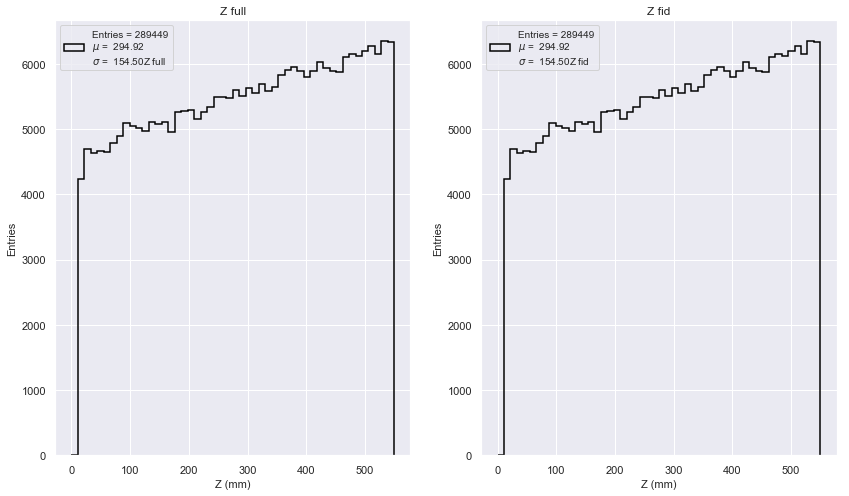

In [43]:
zrange = (0,550)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

(_)     = h1(dst.Z, bins = 50, range =zrange, stats=True, lbl = 'Z full')
plot_histo(PlotLabels('Z (mm)','Entries','Z full'), ax, legendloc='upper left')


ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dstfid.Z, bins = 50, range =zrange, stats=True, lbl = 'Z fid')
plot_histo(PlotLabels('Z (mm)','Entries','Z fid'), ax, legendloc='upper left')


## Geometrical correction


In [44]:
from krcal.core.io_functions       import read_maps
emaps = read_maps(filename='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_100_100_r_6880.h5')

In [45]:
emaps.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx             100
ny             100
run_number    6880
dtype: int64

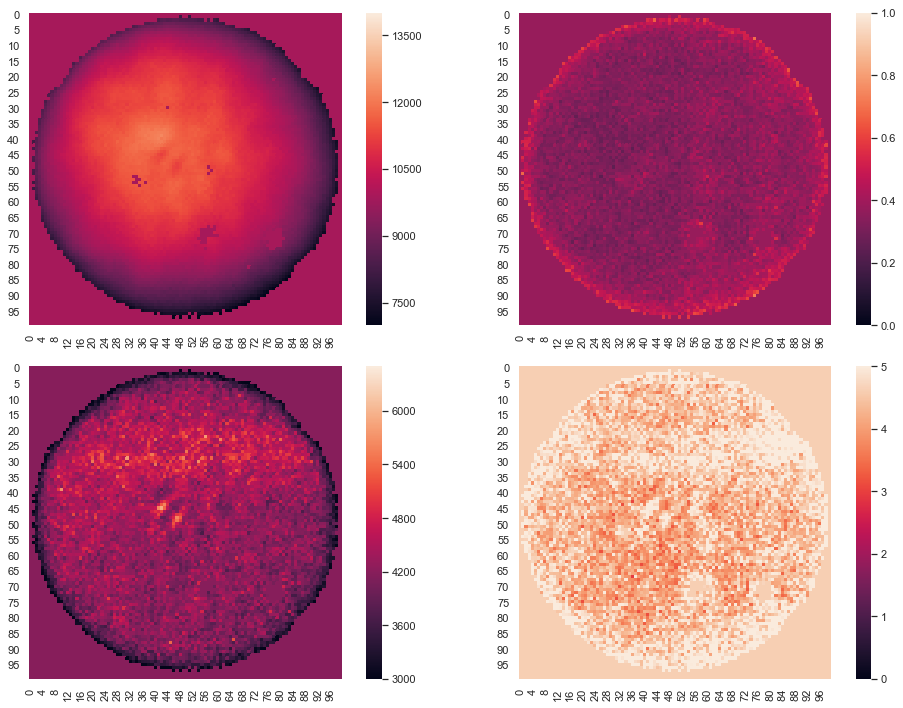

In [46]:
from krcal.core.xy_maps_functions   import draw_xy_maps
draw_xy_maps(emaps,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 6500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [47]:
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
amap_average(emaps)

ASectorMap(chi2=1.0920269937202256, e0=10023.812875074369, lt=4237.16818306769, e0u=0.3709764916950251, ltu=4.5826858217958755, mapinfo=None)

In [48]:
norm = amap_max(emaps)
norm

ASectorMap(chi2=474.03584959519804, e0=12265.34688292703, lt=5912.669038486934, e0u=0.7257233413347788, ltu=7.948447392660727, mapinfo=None)

In [49]:
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.core_functions       import timeit

ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 2.454082727432251 s


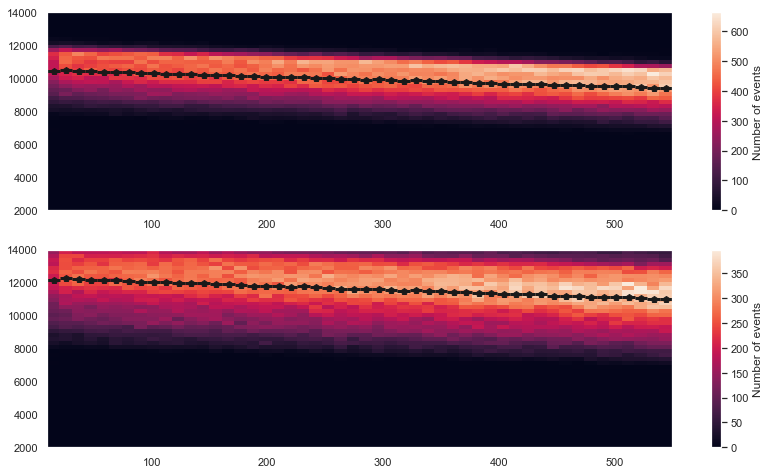

In [50]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

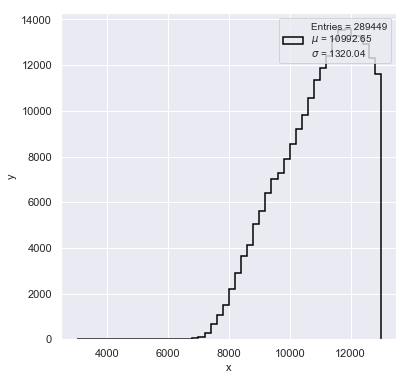

In [51]:
(_) = h1d(E0, bins = 50, range =(3000,13000))

### Geometrical map has changed!

### Central region

In [52]:
dst_R     = dst[dst.R < RCORE]

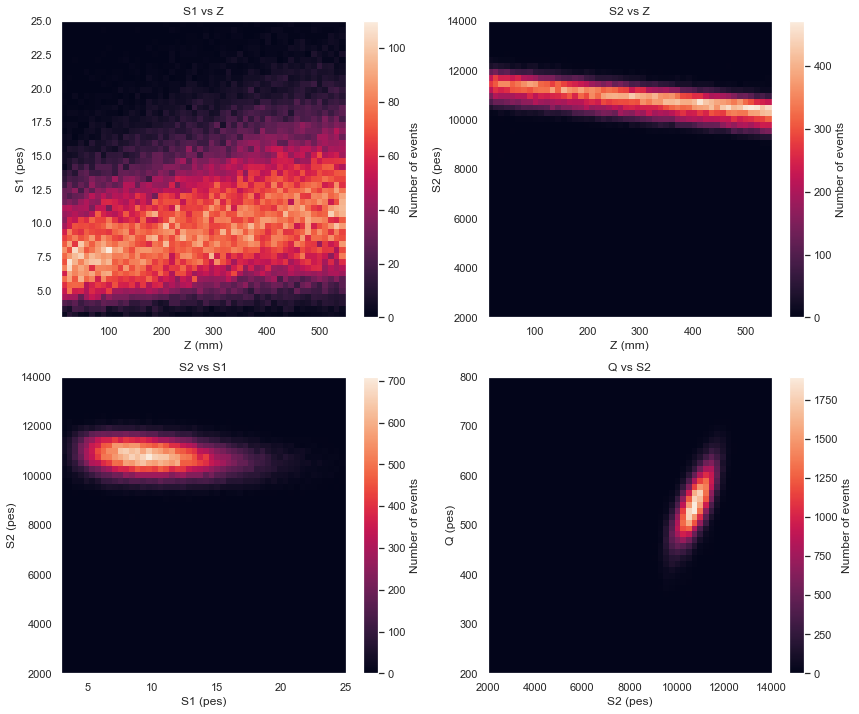

In [53]:
plot_energy_distributions(dst_R, krBins.Z, krBins.S1e, krBins.S2e, krBins.S2q, figsize=(14,12))

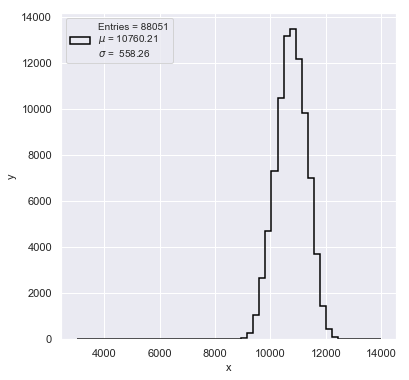

In [54]:
(_) = h1d(dst_R.S2e, bins = 50, range =(3000,14000), legendloc='upper left')

### Write dst

In [55]:
kdst_write(dst, output_dst_filename);

In [56]:
print('written filtered dst ', output_dst_filename)

written filtered dst  /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6884_trigger1_0000_1718.h5


### Read again, this time use new map (for this run)

In [57]:
emaps = read_maps(filename='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_xy_100_100_r_6884.h5')

In [58]:
emaps.mapinfo

xmin          -200
xmax           200
ymin          -200
ymax           200
nx              50
ny              50
run_number    6884
dtype: int64

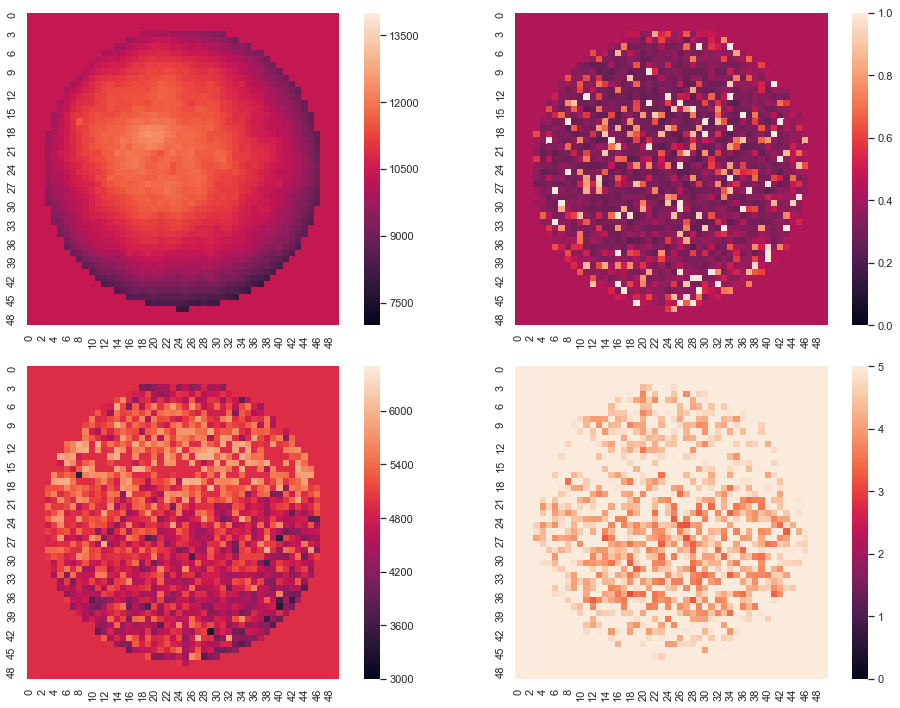

In [59]:
draw_xy_maps(emaps,
            e0lims  = (7000, 14000),
            ltlims  = (3000, 6500),
            eulims  = (0.0,  1),
            lulims  = (0, 5),
            figsize=(14,10))

In [107]:
norm = amap_max(emaps)

In [108]:
ti = timeit(e0_xy_correction)
E0 = ti(dst.S2e.values,
        dst.X.values,
        dst.Y.values,
        E0M = emaps.e0 / norm.e0, 
        xr  = krRanges.X,
        yr  = krRanges.Y,
        nx  = krNbins.X, 
        ny  = krNbins.Y)

Time spent in e0_xy_correction: 2.131484031677246 s


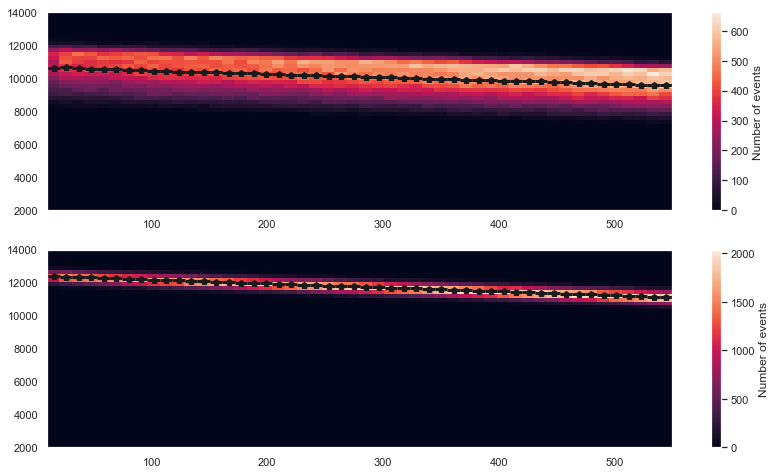

In [109]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(2, 1, 1)
nevt = h2(dst.Z, dst.S2e, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)
ax      = fig.add_subplot(2, 1, 2)
nevt = h2(dst.Z, E0, 50, 50, krRanges.Z, krRanges.S2e, 
           profile=True)

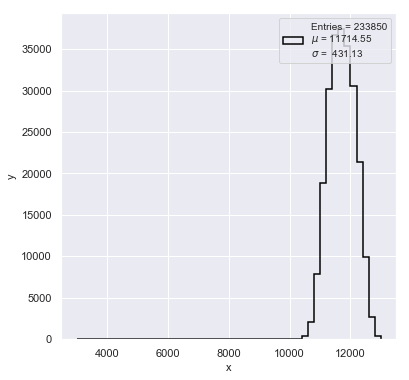

In [110]:
(_) = h1d(E0, bins = 50, range =(3000,13000))

### Geometrical map has changed with new DAQ!

In [111]:
dst = dst.assign(E0=E0)

In [112]:
dst = dst[in_range(dst.E0, 1e+4,13e+4)]

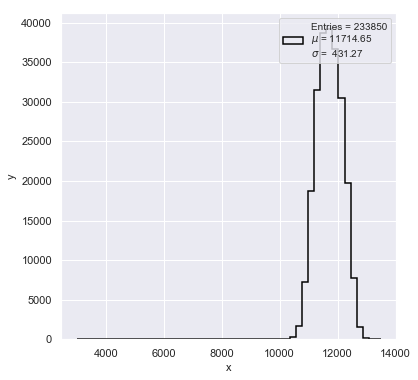

In [113]:
(_) = h1d(dst.E0, bins = 50, range =(3000,13500))

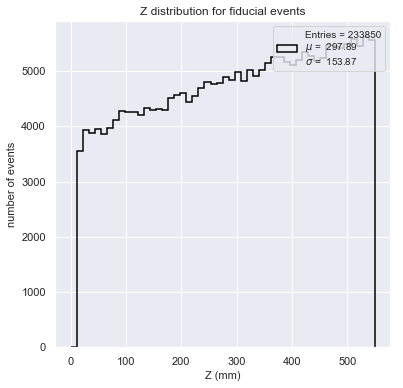

In [114]:
(_) = h1d(dst.Z, bins = 50, range =(0,550),
         pltLabels=PlotLabels(x='Z (mm)', y='number of events', title='Z distribution for fiducial events'))

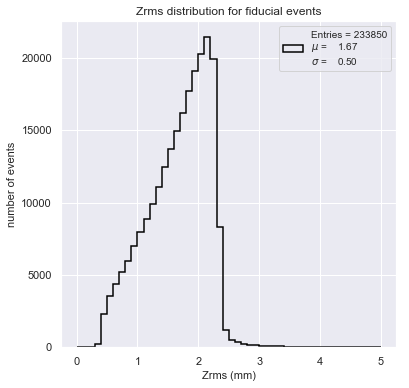

In [115]:
(_) = h1d(dst.Zrms, bins = 50, range =(0,5),
         pltLabels=PlotLabels(x='Zrms (mm)', y='number of events', title='Zrms distribution for fiducial events'))

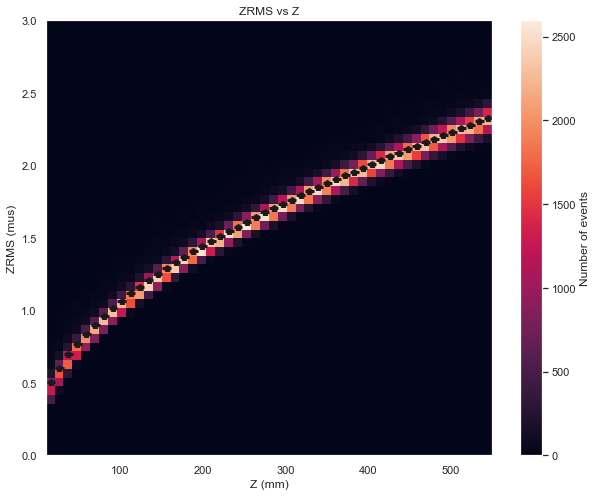

In [116]:
nevt = h2d(dst.Z, dst.Zrms, 50, 50, (10,550), (0,3), 
           pltLabels=PlotLabels(x='Z (mm)', y='ZRMS (mus)', title='ZRMS vs Z'),
           profile=True,
           figsize=(10,8))

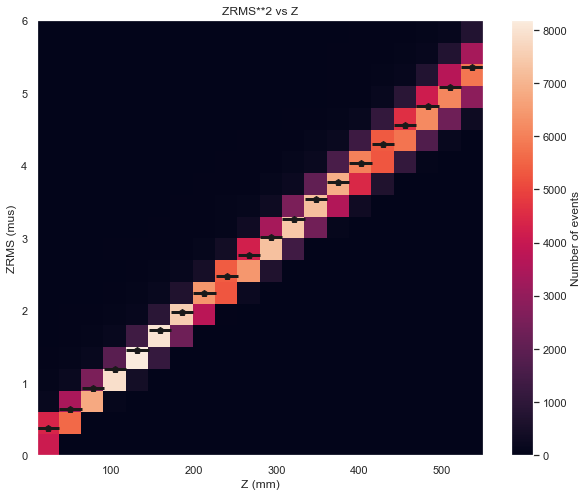

In [117]:
nevt = h2d(dst.Z, dst.Zrms * dst.Zrms, 20, 20, (10,550), (0,6), 
           pltLabels=PlotLabels(x='Z (mm)', y='ZRMS (mus)', title='ZRMS**2 vs Z'),
           profile=True,
           figsize=(10,8))

In [118]:
x, y, yu  = profile1d(dst.Z, dst.Zrms * dst.Zrms, 20, range_z=(10, 500))

In [119]:
fh     = fitf.fit(fitf.polynom, x, y, seed=(1,1), fit_range=(10,500), sigma=0.01*y)
fh

FitFunction(fn=<function fit.<locals>.<lambda> at 0x1a20a5e7b8>, values=array([0.15344523, 0.00975036]), errors=array([3.36686087e-03, 3.12548279e-05]), chi2=1.2007434698653336, pvalue=0.24960281915007224, cov=array([[ 1.13357521e-05, -6.75213887e-08],
       [-6.75213887e-08,  9.76864267e-10]]))

Text(0, 0.5, 'Zrms2')

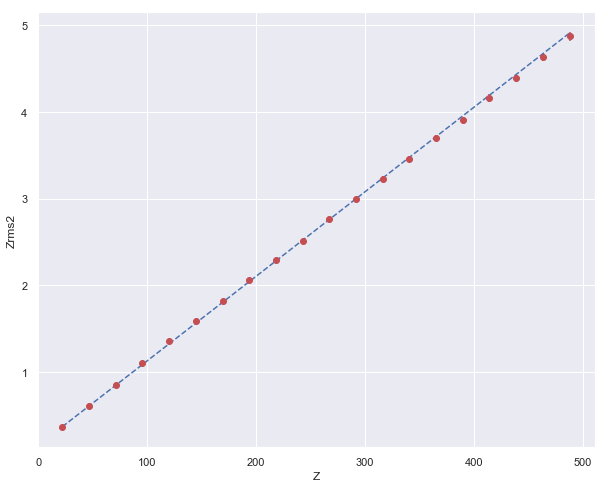

In [120]:
fig = plt.figure(figsize=(10,8))
ax      = fig.add_subplot(1, 1, 1)
plt.errorbar(x, y,  yerr=0.01*y, fmt='ro')
plt.plot(x, fh.fn(x), 'b--')
plt.xlabel('Z')
plt.ylabel('Zrms2')

In [121]:
def z_from_s2rms(s2rms : np.array,  fh)->np.array:
    zr = (s2rms * s2rms - fh.values[0]) / fh.values[1]
    return zr 

In [122]:
zs2w = z_from_s2rms(dst.Zrms, fh)

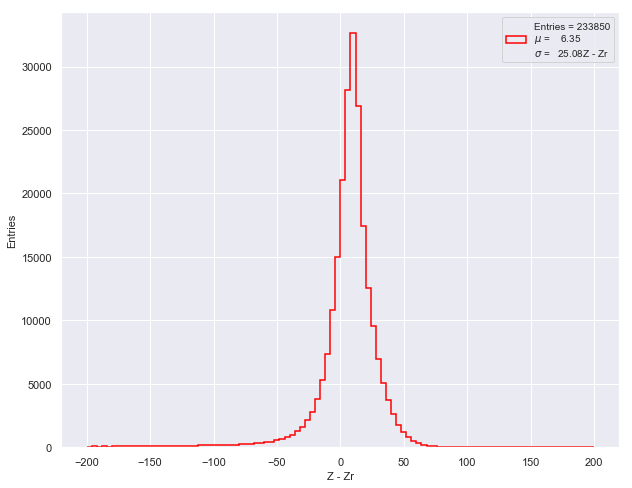

In [123]:
fig = plt.figure(figsize=(10,8))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(dst.Z - zs2w, bins=100, range = (-200,200), color='red', stats=True, lbl='Z - Zr')
plot_histo(PlotLabels('Z - Zr','Entries',''), ax)

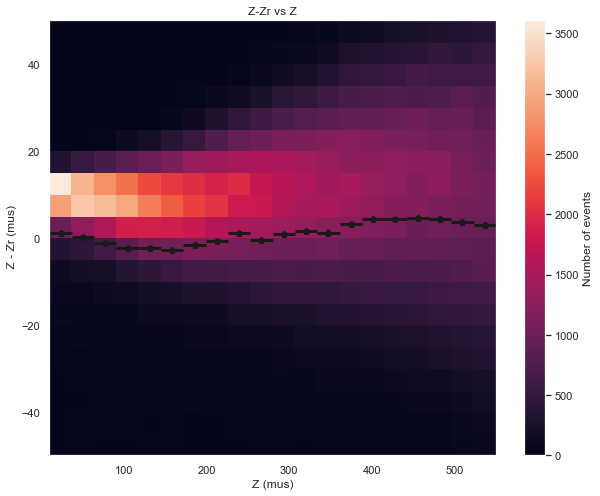

In [124]:
nevt = h2d(dst.Z, dst.Z - zs2w, 20, 20, (10,550), (-50,50), 
           pltLabels=PlotLabels(x='Z (mus)', y=' Z - Zr (mus)', title='Z-Zr vs Z'),
           profile=True,
           figsize=(10,8))

### Filter

In [125]:
range_krs2 = (10e+3,14e+3)

In [126]:
sel_krband, fpl, fph, hp, pp = selection_in_band(dst.Z, dst.E0,
                                                 range_z = (10,550),
                                                 range_e = (8000,13000),
                                                 nbins_z = 50,
                                                 nbins_e = 50,
                                                 nsigma  = 3.5)

/Users/jjgomezcadenas/Projects/ICAROS/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)
/Users/jjgomezcadenas/Projects/ICAROS/krcal/core/fit_functions.py:45: UserWarning: nof = 0 in chi2 calculation, return chi2 = {chi2_}
  warnings.warn('nof = 0 in chi2 calculation, return chi2 = {chi2_}', UserWarning)


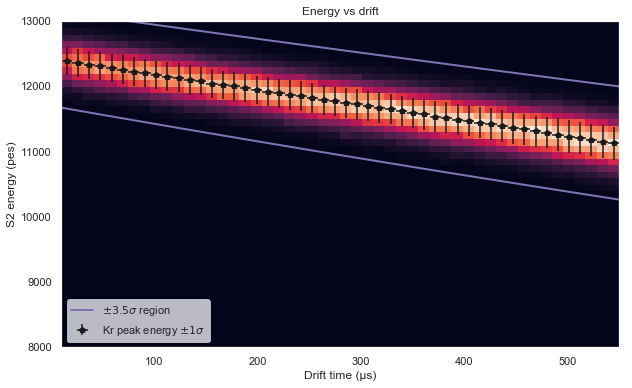

In [127]:
plot_selection_in_band(fpl, fph, hp, pp)

In [128]:
selection_info(sel_krband, 'Kr band')

Total number of selected candidates Kr band: 233796 (100.0 %)


'Total number of selected candidates Kr band: 233796 (100.0 %)'

In [129]:
dsts = dst[sel_krband]

### Energy before and after filter

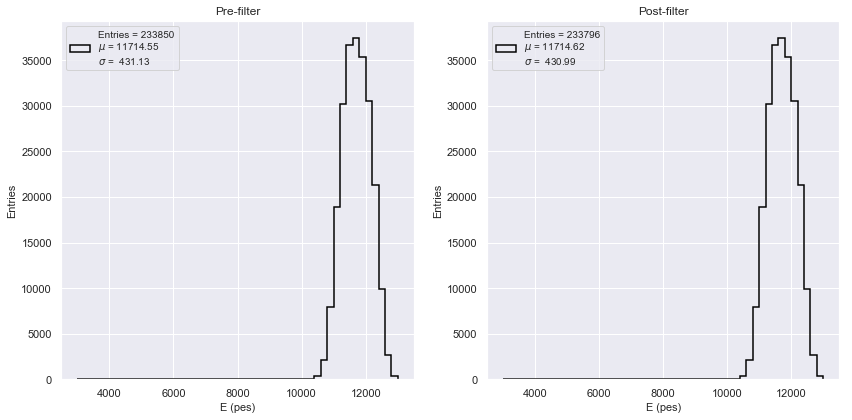

In [130]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(dst.E0,  bins = 50, range =(3000,13000))
plot_histo(PlotLabels('E (pes)','Entries','Pre-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dsts.E0,  bins = 50, range =(3000,13000))
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
plt.tight_layout()

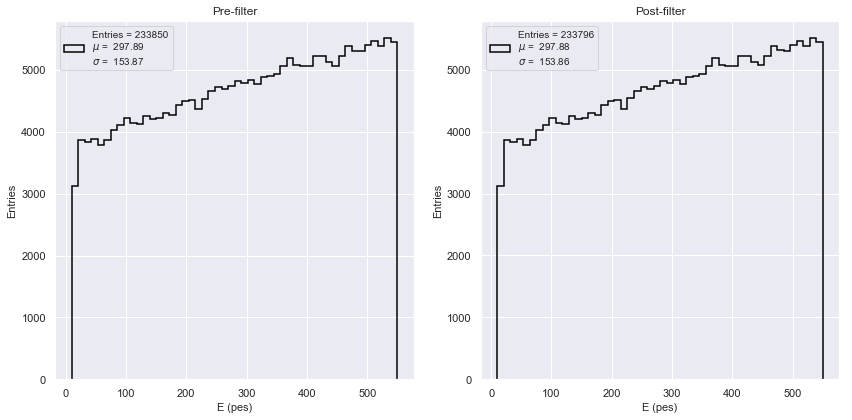

In [131]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(dst.Z,  bins = 50, range =(10,550))
plot_histo(PlotLabels('E (pes)','Entries','Pre-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dsts.Z,  bins = 50, range =(10,550))
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
plt.tight_layout()

In [132]:
dstf = dsts[in_range(dsts.Nsipm, 15, 30)]

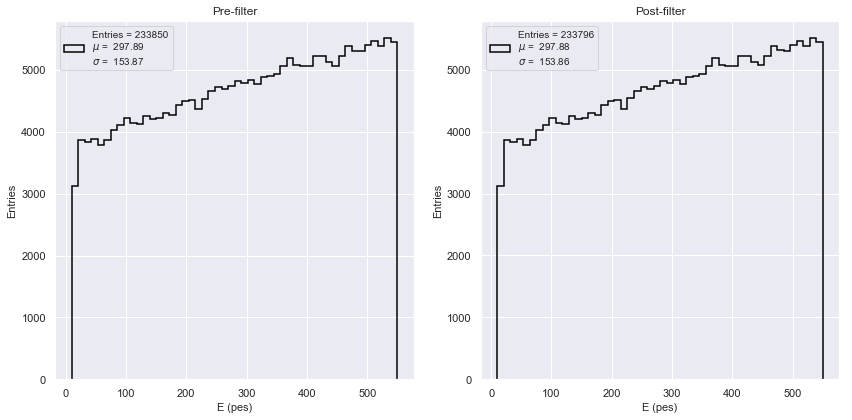

In [133]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(dst.Z,  bins = 50, range =(10,550))
plot_histo(PlotLabels('E (pes)','Entries','Pre-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dstf.Z,  bins = 50, range =(10,550))
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
plt.tight_layout()

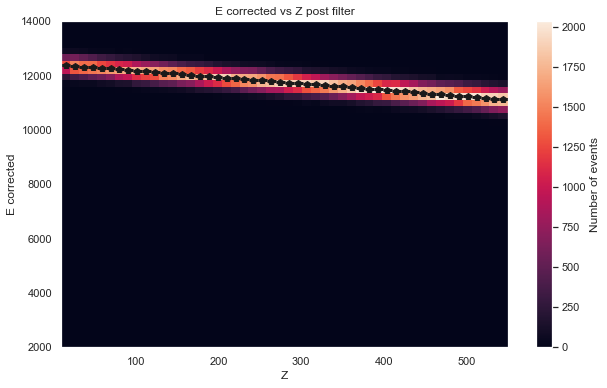

In [134]:
nevt = h2d(dstf.Z, dstf.E0, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z', y='E corrected', title='E corrected vs Z post filter'),
           profile=True,
           figsize=(10,6))

In [135]:
from krcal.core.correction_functions import lt_xy_correction
ti = timeit(lt_xy_correction)
E = ti(dstf.E0.values, 
       dstf.X.values, 
       dst.Y.values,
       dstf.Z.values, 
       LTM = emaps.lt,
       xr  = krRanges.X,
       yr  = krRanges.Y,
       nx  = krNbins.X, 
       ny  = krNbins.Y)



Time spent in lt_xy_correction: 2.0651841163635254 s


In [136]:
dstf = dstf.assign(E=E)

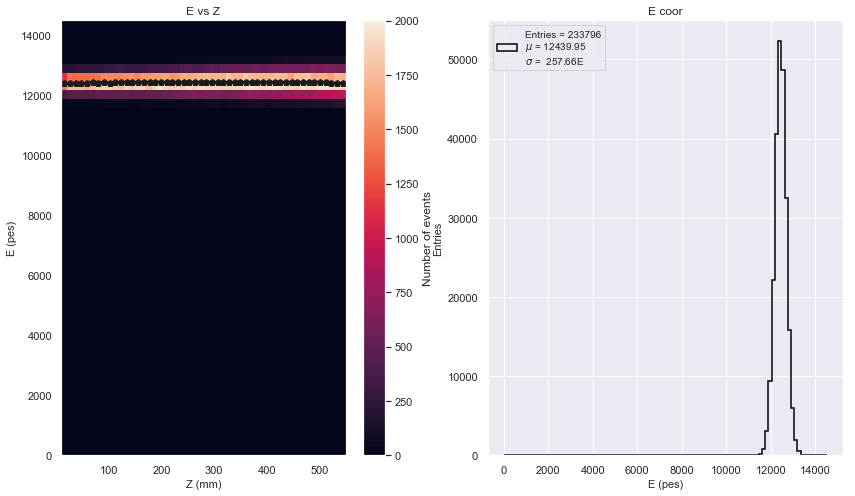

In [137]:
e_range = (0, 14500)
zrange = (10,550)
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dstf.Z, dstf.E, krNbins.Z, krNbins.S2e, krRanges.Z, e_range, profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =e_range, stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','E coor'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 12439.243149905655 +-0.5355049006449064 
 E sigma   = 255.33315670963356 +-0.40885498106842755 
 chi2    = 1.5629610310869524 
 sigma E/E (FWHM)     (%) =4.823709216361687
 sigma E/E (FWHM) Qbb (%) =0.6229914821280602 


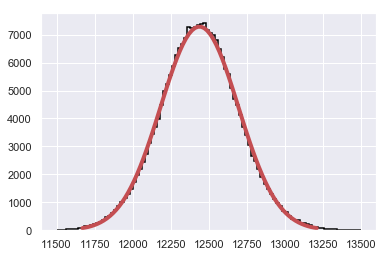

In [138]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy


fc = fit_energy(E, nbins=100, range=(11500, 13500))
plot_fit_energy(fc)
print_fit_energy(fc)

In [139]:
rrange = (0, 170)
erange = (11000, 13000)
zrange = (50,550)
sel = in_range(dstf.R, *rrange) & in_range(dstf.Z, *z_range) &  in_range(dstf.E, *e_range)

In [140]:
dst = dstf[sel]

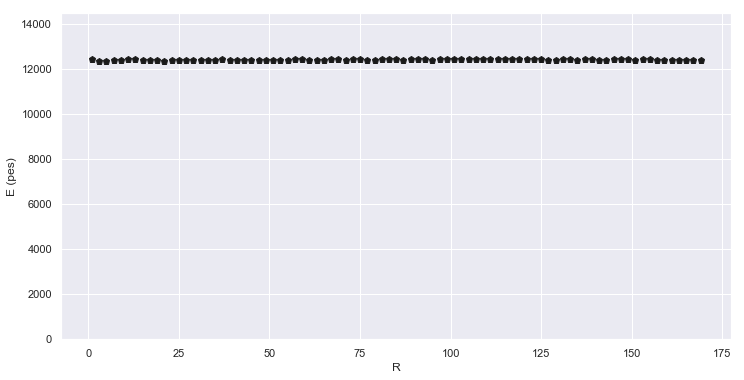

In [141]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

energy_X_profile(dst.R, dst.E, xnbins = 100, xrange=(0,200), xlabel = 'R',
                 erange=e_range,  
                 figsize=(12,6))

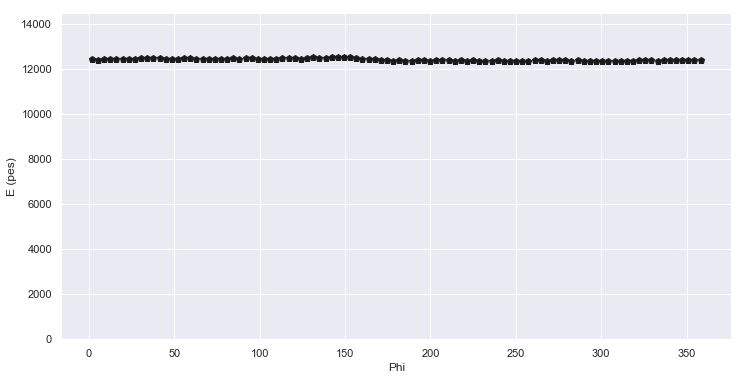

In [142]:
from krcal.core.core_functions      import phirad_to_deg
energy_X_profile(phirad_to_deg(dst.Phi), dst.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=e_range,  
                 figsize=(12,6))

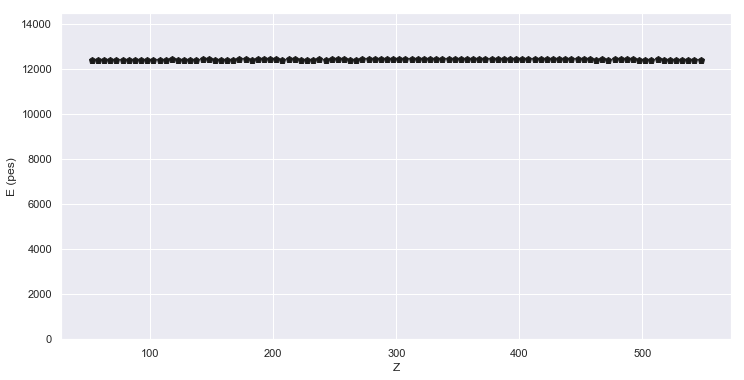

In [143]:
energy_X_profile(dst.Z, dst.E, xnbins = 100, xrange=zrange, xlabel = 'Z',
                 erange=e_range,   
                 figsize=(12,6))

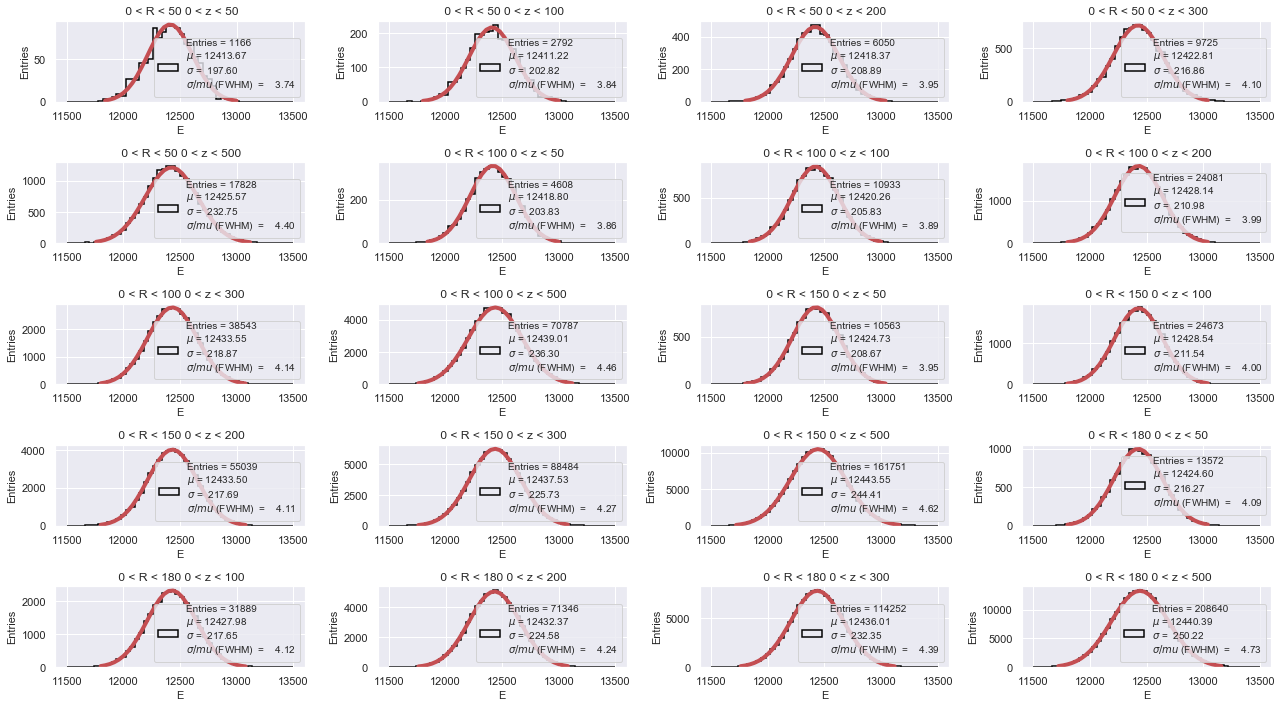

In [144]:
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z
Ri = (50, 100,150,180)
Zi = (50, 100,200,300,500)

FC, FCE = resolution_r_z(Ri, Zi, dst.R, dst.Z, dst.E,
                    enbins = 50,
                    erange = (11500,13500),
                    ixy = (5,4),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10)) 

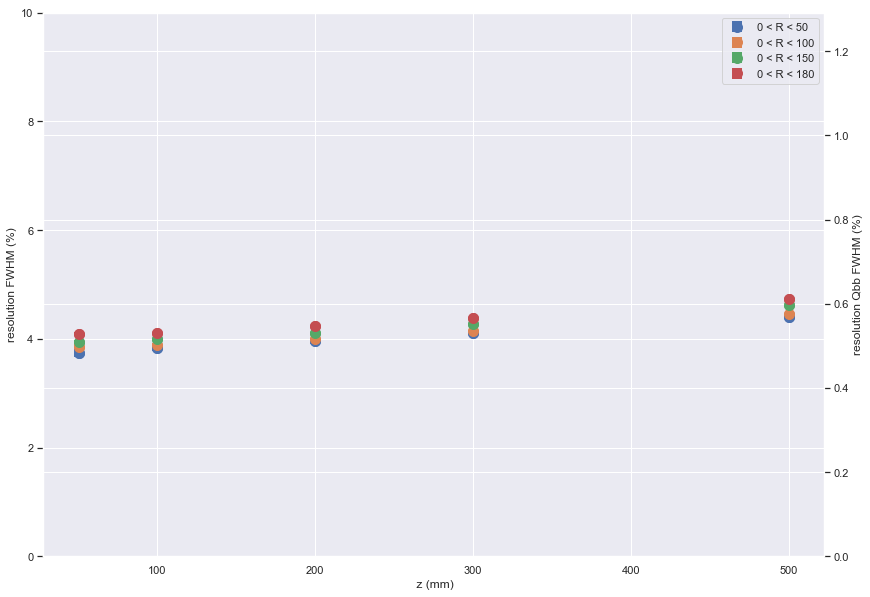

In [145]:
plot_resolution_r_z(Ri, Zi, FC, FCE, r_range=(0,10))

## End of NB